In [1]:
from argparse import ArgumentParser
import torch.nn.functional as F
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from tqdm import tqdm
import os
import time
import sys
import pandas as pd
import itertools
from src.modules import VelocitypredictionHead # rename modules to models
from src.train_test import run
from src.utils import *

pd.set_option('display.max_rows', None)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [2]:
parser = ArgumentParser()
config, _ = parser.parse_known_args()

In [3]:
config.model = 'velocityprediction'
config.output_attentions = True
config.output_hidden_states = True
config.vocab_size = 271 # Time samples
config.hidden_size = 256
config.max_position_embeddings = 20
config.layer_norm_eps = 1e-12
config.hidden_dropout_prob = 0.1
config.num_attention_heads = 4
config.attention_probs_dropout_prob = 0.1
config.intermediate_size = config.hidden_size*4
config.chunk_size_feed_forward = 0
config.num_hidden_layers = 4

In [4]:
# Training Parameter
config.batch_size = 16
config.lr = 5e-4
config.epoch = 500
config.patience = 30

config.vel_size = 271

# I/O parameter
config.parent_dir = './results/finetune/velpred/'
config.model_path = './results/pretrain/'
config.dataset = './data/finetune/'

In [5]:
train_data = torch.load(os.path.join(config.dataset, 'train_data.pt'))
test_data = torch.load(os.path.join(config.dataset, 'test_data.pt'))

vmin_all = -1
vmax_all = 1

config.vel_min = torch.min(train_data.encodings['vel'])
config.vel_max = torch.max(train_data.encodings['vel'])

In [6]:
idx = torch.randint(len(test_data), (2,)) # accounting for batch

inputs_embeds = test_data.encodings['inputs_embeds'][idx]
labels = test_data.encodings['vel'][idx]

labels[1,:].shape

torch.Size([9])

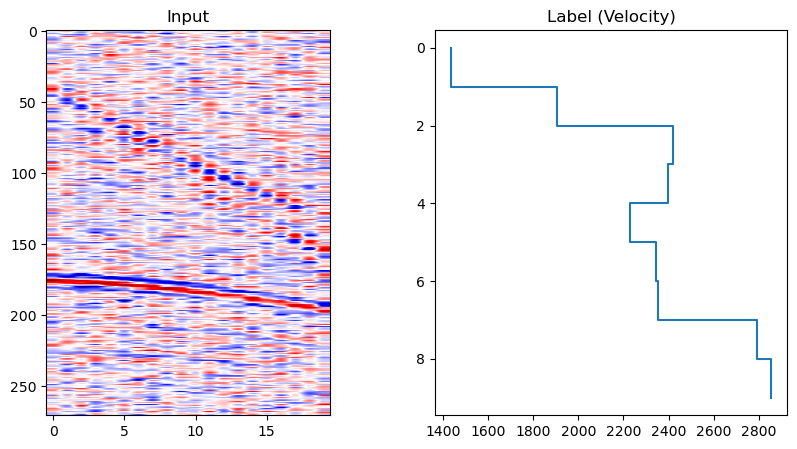

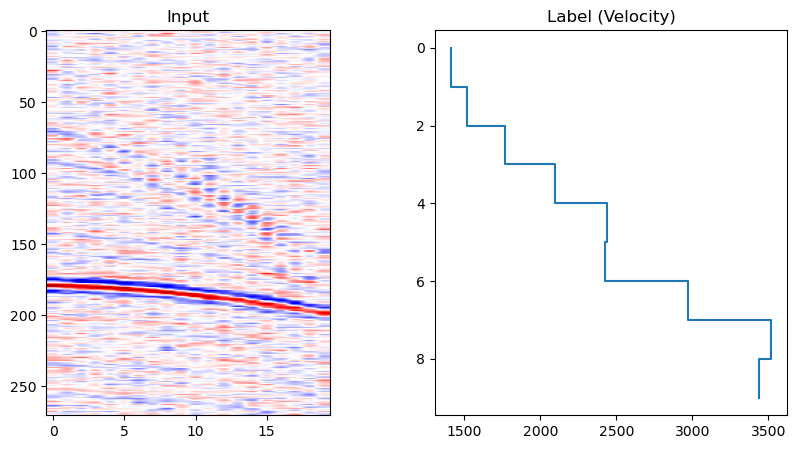

In [7]:
for i in range(len(idx)):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(inputs_embeds[i, :, :].swapaxes(0, 1) - inputs_embeds[i, :, :].mean(), aspect=.1, vmin=vmin_all, vmax=vmax_all, cmap='seismic')
    ax[0].set_title("Input")
    ax[1].step(np.pad(labels[i, :], (0, 1), 'edge'), np.arange(labels[i, :].shape[-1] + 1))
    ax[1].invert_yaxis()
    ax[1].set_title("Label (Velocity)")

In [8]:
train_dataloader = DataLoader(train_data, batch_size=config.batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=config.batch_size, shuffle=True)

In [9]:
if not os.path.exists(config.parent_dir):
    os.makedirs(config.parent_dir)

In [10]:
model = torch.load(os.path.join(config.model_path, "model.pt"))

model.cls = VelocitypredictionHead(config)
print(model)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Linear(in_features=271, out_features=256, bias=True)
      (position_embeddings): PositionalEncoding(
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): PreLNBertAttention(
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): PreLNBertSelfOutput(
              (dense): Linear(in_f

In [11]:
def count_parameters(model):
    table = pd.DataFrame(columns=['Name', 'Parameter'])
    total_params = 0
    i = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        total_params+=param
        table.loc[i] = [name] + [param]
        i += 1
    display(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params


#count_parameters(model)

In [12]:
model.to(device)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Linear(in_features=271, out_features=256, bias=True)
      (position_embeddings): PositionalEncoding(
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): PreLNBertAttention(
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): PreLNBertSelfOutput(
              (dense): Linear(in_f

In [13]:
model, avg_train_loss, avg_test_loss, epoch_count = run(model, train_dataloader, test_dataloader, device, config)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 447.769448 | Average Test Loss: 291.967108  
Validation loss decreased (inf --> 291.967108)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 205.446370 | Average Test Loss: 144.274257  
Validation loss decreased (291.967108 --> 144.274257)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 151.946653 | Average Test Loss: 132.437950  
Validation loss decreased (144.274257 --> 132.437950)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 140.367091 | Average Test Loss: 125.426419  
Validation loss decreased (132.437950 --> 125.426419)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 134.113872 | Average Test Loss: 120.539177  
Validation loss decreased (125.426419 --> 120.539177)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 127.573674 | Average Test Loss: 117.993485  
Validation loss decreased (120.539177 --> 117.993485)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 119.712951 | Average Test Loss: 119.063561  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 115.408692 | Average Test Loss: 116.625544  
Validation loss decreased (117.993485 --> 116.625544)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 113.614741 | Average Test Loss: 114.891123  
Validation loss decreased (116.625544 --> 114.891123)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 110.278290 | Average Test Loss: 110.470408  
Validation loss decreased (114.891123 --> 110.470408)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 109.712198 | Average Test Loss: 111.059047  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 105.797905 | Average Test Loss: 111.259343  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 104.517689 | Average Test Loss: 111.612262  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 104.831139 | Average Test Loss: 111.209648  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 99.492799 | Average Test Loss: 102.451303  
Validation loss decreased (110.470408 --> 102.451303)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 96.614803 | Average Test Loss: 100.567924  
Validation loss decreased (102.451303 --> 100.567924)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 95.046499 | Average Test Loss: 108.492531  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 95.216180 | Average Test Loss: 101.355552  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 94.607758 | Average Test Loss: 105.476864  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 90.124622 | Average Test Loss: 97.846883  
Validation loss decreased (100.567924 --> 97.846883)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 87.674895 | Average Test Loss: 99.241509  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 89.291236 | Average Test Loss: 100.101851  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 88.846612 | Average Test Loss: 98.944065  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 87.420076 | Average Test Loss: 100.990512  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 84.765758 | Average Test Loss: 98.194780  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 80.488861 | Average Test Loss: 98.080377  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 80.478300 | Average Test Loss: 98.785854  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 81.189279 | Average Test Loss: 94.933020  
Validation loss decreased (97.846883 --> 94.933020)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 80.488752 | Average Test Loss: 99.257846  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 78.305347 | Average Test Loss: 92.747475  
Validation loss decreased (94.933020 --> 92.747475)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 75.240747 | Average Test Loss: 93.520887  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 75.073531 | Average Test Loss: 92.805289  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 73.469294 | Average Test Loss: 96.600464  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 71.938690 | Average Test Loss: 95.821242  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 71.214716 | Average Test Loss: 93.016110  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 69.291466 | Average Test Loss: 96.623185  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 71.274118 | Average Test Loss: 95.340518  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 68.340007 | Average Test Loss: 93.070888  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 65.558591 | Average Test Loss: 91.758168  
Validation loss decreased (92.747475 --> 91.758168)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 66.966332 | Average Test Loss: 92.467577  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 67.514245 | Average Test Loss: 92.614312  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 64.799263 | Average Test Loss: 93.340265  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 63.352053 | Average Test Loss: 90.425136  
Validation loss decreased (91.758168 --> 90.425136)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 62.794666 | Average Test Loss: 93.444793  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 63.705773 | Average Test Loss: 90.576734  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 62.353102 | Average Test Loss: 89.682999  
Validation loss decreased (90.425136 --> 89.682999)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 59.998102 | Average Test Loss: 90.436875  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 60.174847 | Average Test Loss: 92.850638  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 60.753850 | Average Test Loss: 89.505391  
Validation loss decreased (89.682999 --> 89.505391)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 59.324140 | Average Test Loss: 94.158761  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 60.366247 | Average Test Loss: 90.306202  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 59.339501 | Average Test Loss: 92.350581  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 57.870012 | Average Test Loss: 87.137142  
Validation loss decreased (89.505391 --> 87.137142)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 56.740104 | Average Test Loss: 88.392822  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 54.780575 | Average Test Loss: 89.564700  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 54.288513 | Average Test Loss: 88.279035  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 53.883065 | Average Test Loss: 88.552171  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 55.809134 | Average Test Loss: 91.106398  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 54.223827 | Average Test Loss: 89.507532  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 54.312827 | Average Test Loss: 87.841248  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 53.600154 | Average Test Loss: 87.001043  
Validation loss decreased (87.137142 --> 87.001043)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 53.764362 | Average Test Loss: 89.646412  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 53.835455 | Average Test Loss: 86.653785  
Validation loss decreased (87.001043 --> 86.653785)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 53.767338 | Average Test Loss: 87.092699  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 51.581181 | Average Test Loss: 87.889385  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 53.974788 | Average Test Loss: 87.495185  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 51.710451 | Average Test Loss: 86.231693  
Validation loss decreased (86.653785 --> 86.231693)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 49.976167 | Average Test Loss: 86.729914  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 51.043649 | Average Test Loss: 86.277335  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 51.686936 | Average Test Loss: 86.014950  
Validation loss decreased (86.231693 --> 86.014950)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 50.271941 | Average Test Loss: 89.604299  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 49.716530 | Average Test Loss: 86.676885  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 47.413335 | Average Test Loss: 86.598383  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 48.278346 | Average Test Loss: 84.967308  
Validation loss decreased (86.014950 --> 84.967308)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 48.146838 | Average Test Loss: 85.447962  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 48.234017 | Average Test Loss: 85.543370  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 47.616606 | Average Test Loss: 88.602075  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 48.784394 | Average Test Loss: 87.117852  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 47.415889 | Average Test Loss: 88.055296  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 47.337614 | Average Test Loss: 86.987813  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 47.307726 | Average Test Loss: 86.106627  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 47.437502 | Average Test Loss: 85.255497  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 46.231774 | Average Test Loss: 85.192993  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 47.109906 | Average Test Loss: 87.428333  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 46.651662 | Average Test Loss: 86.745312  
EarlyStopping counter: 11 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 46.637929 | Average Test Loss: 86.029245  
EarlyStopping counter: 12 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 46.751981 | Average Test Loss: 88.770476  
EarlyStopping counter: 13 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 45.678914 | Average Test Loss: 85.956978  
EarlyStopping counter: 14 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 47.588703 | Average Test Loss: 84.647811  
Validation loss decreased (84.967308 --> 84.647811)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 45.817998 | Average Test Loss: 87.847675  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 45.557295 | Average Test Loss: 86.554940  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 44.058931 | Average Test Loss: 84.787333  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 44.958496 | Average Test Loss: 85.632170  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 44.559615 | Average Test Loss: 84.798932  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 43.345783 | Average Test Loss: 82.955108  
Validation loss decreased (84.647811 --> 82.955108)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 43.861331 | Average Test Loss: 84.704282  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 45.330347 | Average Test Loss: 86.025244  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 45.052851 | Average Test Loss: 85.893425  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 43.431174 | Average Test Loss: 85.916129  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 43.621195 | Average Test Loss: 87.311053  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 43.371054 | Average Test Loss: 84.524280  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 43.242089 | Average Test Loss: 84.101413  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 44.636379 | Average Test Loss: 85.050506  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 43.255097 | Average Test Loss: 85.318668  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 43.328120 | Average Test Loss: 85.166250  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 42.392931 | Average Test Loss: 84.902496  
EarlyStopping counter: 11 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 41.688321 | Average Test Loss: 85.280872  
EarlyStopping counter: 12 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 43.468130 | Average Test Loss: 84.705713  
EarlyStopping counter: 13 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 43.139202 | Average Test Loss: 86.106783  
EarlyStopping counter: 14 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 41.701023 | Average Test Loss: 83.913391  
EarlyStopping counter: 15 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 41.690714 | Average Test Loss: 83.887747  
EarlyStopping counter: 16 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 40.765771 | Average Test Loss: 83.583232  
EarlyStopping counter: 17 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 41.529251 | Average Test Loss: 83.635830  
EarlyStopping counter: 18 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 42.171207 | Average Test Loss: 87.443597  
EarlyStopping counter: 19 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 41.798242 | Average Test Loss: 82.886052  
Validation loss decreased (82.955108 --> 82.886052)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 40.902667 | Average Test Loss: 84.810499  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 42.293112 | Average Test Loss: 85.754200  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 40.409528 | Average Test Loss: 85.831275  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 40.811780 | Average Test Loss: 83.520149  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 40.480035 | Average Test Loss: 85.738123  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 40.336306 | Average Test Loss: 83.181221  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 39.862794 | Average Test Loss: 84.164998  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 41.145848 | Average Test Loss: 85.804636  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 41.612808 | Average Test Loss: 85.988724  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 40.569516 | Average Test Loss: 86.040328  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 40.447816 | Average Test Loss: 84.264253  
EarlyStopping counter: 11 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 41.466535 | Average Test Loss: 86.683749  
EarlyStopping counter: 12 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 39.432761 | Average Test Loss: 82.860247  
Validation loss decreased (82.886052 --> 82.860247)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 38.983644 | Average Test Loss: 83.681543  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 40.346820 | Average Test Loss: 84.091189  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 41.638296 | Average Test Loss: 87.725558  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 41.036148 | Average Test Loss: 87.168906  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 40.055342 | Average Test Loss: 84.566793  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 39.017668 | Average Test Loss: 84.806968  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 38.663473 | Average Test Loss: 82.651957  
Validation loss decreased (82.860247 --> 82.651957)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 39.294933 | Average Test Loss: 85.656879  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 38.620869 | Average Test Loss: 85.059602  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 38.878914 | Average Test Loss: 82.555071  
Validation loss decreased (82.651957 --> 82.555071)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 39.619765 | Average Test Loss: 84.983439  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 39.696523 | Average Test Loss: 81.669775  
Validation loss decreased (82.555071 --> 81.669775)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 38.744060 | Average Test Loss: 83.343573  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 37.690368 | Average Test Loss: 83.863046  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 38.253432 | Average Test Loss: 83.359575  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 39.168833 | Average Test Loss: 84.222756  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 38.219731 | Average Test Loss: 83.060011  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 38.284266 | Average Test Loss: 82.569820  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 37.400151 | Average Test Loss: 84.039529  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 37.583226 | Average Test Loss: 83.428928  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 38.316850 | Average Test Loss: 82.987306  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 37.047449 | Average Test Loss: 82.537290  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 37.214080 | Average Test Loss: 82.575612  
EarlyStopping counter: 11 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 37.277407 | Average Test Loss: 85.548086  
EarlyStopping counter: 12 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 37.313640 | Average Test Loss: 82.532432  
EarlyStopping counter: 13 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 37.420552 | Average Test Loss: 83.846357  
EarlyStopping counter: 14 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 37.477086 | Average Test Loss: 80.903450  
Validation loss decreased (81.669775 --> 80.903450)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 37.882485 | Average Test Loss: 84.271245  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 37.602927 | Average Test Loss: 83.063340  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 37.411330 | Average Test Loss: 83.915509  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 38.092648 | Average Test Loss: 85.040313  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 37.573779 | Average Test Loss: 83.848754  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 37.706775 | Average Test Loss: 83.540278  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 36.383598 | Average Test Loss: 82.627622  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 37.181175 | Average Test Loss: 81.451194  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 36.200084 | Average Test Loss: 82.538194  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 36.146824 | Average Test Loss: 82.937375  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 36.670229 | Average Test Loss: 79.615263  
Validation loss decreased (80.903450 --> 79.615263)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 35.986504 | Average Test Loss: 82.447054  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 35.626998 | Average Test Loss: 82.628841  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 36.231912 | Average Test Loss: 82.528982  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 35.900373 | Average Test Loss: 82.751523  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 35.124419 | Average Test Loss: 81.970894  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 35.242939 | Average Test Loss: 81.544648  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 35.040973 | Average Test Loss: 79.502686  
Validation loss decreased (79.615263 --> 79.502686)
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 36.605217 | Average Test Loss: 81.754675  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 35.836374 | Average Test Loss: 84.118890  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 35.081419 | Average Test Loss: 81.695040  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 34.502037 | Average Test Loss: 81.715295  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 34.839193 | Average Test Loss: 81.266380  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 36.231196 | Average Test Loss: 82.495926  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 36.107056 | Average Test Loss: 82.731261  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 35.980542 | Average Test Loss: 83.186807  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 36.113124 | Average Test Loss: 82.949352  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 34.774610 | Average Test Loss: 81.911783  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 35.379650 | Average Test Loss: 82.881773  
EarlyStopping counter: 11 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 34.703812 | Average Test Loss: 82.282801  
EarlyStopping counter: 12 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 35.671556 | Average Test Loss: 82.618261  
EarlyStopping counter: 13 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 35.018681 | Average Test Loss: 82.716007  
EarlyStopping counter: 14 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 34.979114 | Average Test Loss: 83.605376  
EarlyStopping counter: 15 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 33.865243 | Average Test Loss: 81.936770  
EarlyStopping counter: 16 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 34.758088 | Average Test Loss: 82.797749  
EarlyStopping counter: 17 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 34.391772 | Average Test Loss: 82.234613  
EarlyStopping counter: 18 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 35.783169 | Average Test Loss: 83.515133  
EarlyStopping counter: 19 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 34.368129 | Average Test Loss: 82.720437  
EarlyStopping counter: 20 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 33.413764 | Average Test Loss: 81.101730  
EarlyStopping counter: 21 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 34.768742 | Average Test Loss: 83.223383  
EarlyStopping counter: 22 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 34.739958 | Average Test Loss: 82.282638  
EarlyStopping counter: 23 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 34.905455 | Average Test Loss: 85.177464  
EarlyStopping counter: 24 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 35.069371 | Average Test Loss: 83.924655  
EarlyStopping counter: 25 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 34.199297 | Average Test Loss: 82.790720  
EarlyStopping counter: 26 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 34.092784 | Average Test Loss: 85.594067  
EarlyStopping counter: 27 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 35.489456 | Average Test Loss: 84.356443  
EarlyStopping counter: 28 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 34.347881 | Average Test Loss: 82.556329  
EarlyStopping counter: 29 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Average Train Loss: 34.100552 | Average Test Loss: 83.031351  
EarlyStopping counter: 30 out of 30
Early stopping


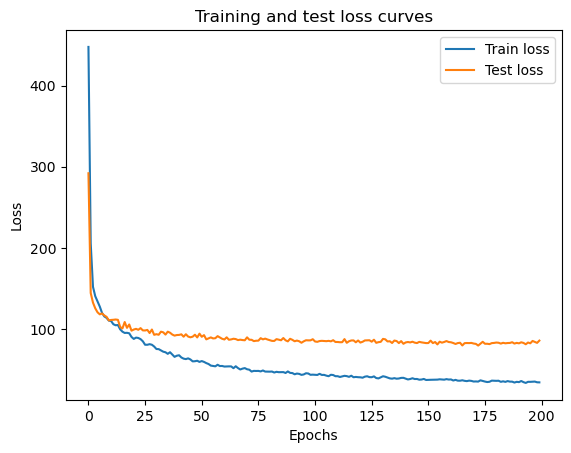

In [14]:
def plot_loss(epoch_count, train_loss, test_loss):
    # Plot Test and Train Loss
    plt.plot(epoch_count[:200], train_loss[:200], label="Train loss")
    plt.plot(epoch_count[:200], test_loss[:200], label="Test loss")
    plt.title("Training and test loss curves")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    #plt.savefig('loss.png');

plot_loss(epoch_count, avg_train_loss, avg_test_loss)

tensor([122, 214])


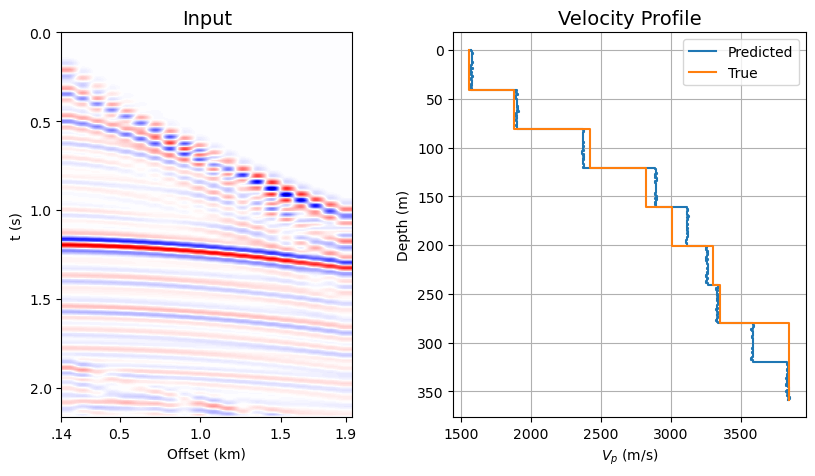

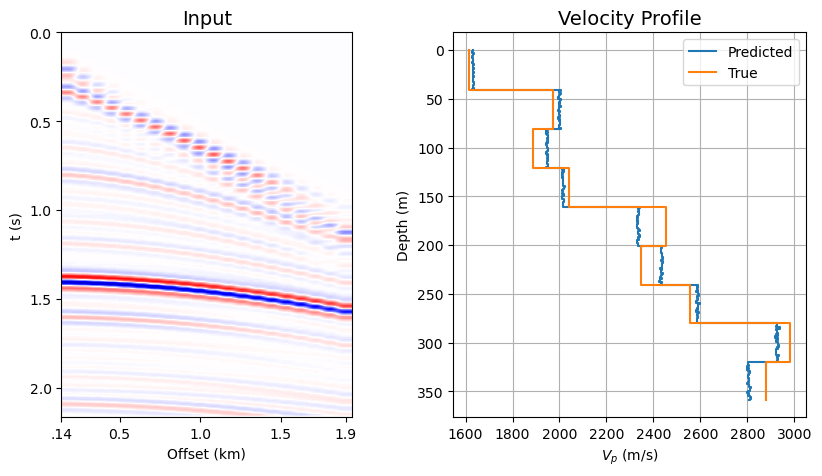

In [22]:
# Acquisition information

x0 = 0.14 # Near offset
dx = 0.09 # Offset increment
dt = 0.008 # Time step

model.eval()

idx = torch.randint(len(test_data), (2,))
print(idx)

inputs_embeds = test_data.encodings['labels'][idx]
labels = F.interpolate(test_data.encodings['vel'][idx].unsqueeze(0).unsqueeze(0), 
                       size=(len(test_data.encodings['vel'][idx]), 271), 
                       mode='nearest')

labels = labels.squeeze()

with torch.no_grad():
    sample_output = model(inputs_embeds=inputs_embeds.to(device))

# sample_output.logits = torch.mean(sample_output.logits, 1)

for X, y, z in zip(inputs_embeds.cpu(), sample_output.logits.cpu(), labels):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(1 * (X - X.mean()).detach().swapaxes(0, 1) * 1, aspect=1.1, vmin=-1, vmax=1, cmap='seismic', extent=[x0, x0 + 20 * dx, 271 * dt, 0])
    ax[0].set_title("Input", fontsize=14)
    ax[0].set_xticks([x0, 0.5, 1, 1.5, 1.9])
    ax[0].set_xticklabels([".14", "0.5", "1.0", "1.5", "1.9"])
    ax[0].set_yticks(np.arange(0, 2.5, 0.5))
    ax[0].set_ylabel("t (s)")
    ax[0].set_xlabel("Offset (km)")
    ax[1].step(y, np.arange(0, 40*9, 40*9/(271)), label="Predicted")
    ax[1].step(z, np.arange(0, 40*9, 40*9/(271)), label="True")
    ax[1].invert_yaxis()
    ax[1].grid()
    ax[1].legend()
    ax[1].set_ylabel("Depth")
    ax[1].set_xlabel("$V_p$ (m/s)")
    ax[1].set_ylabel("Depth (m)")
    ax[1].set_title("Velocity Profile", fontsize=14)

In [24]:
# Save everything
print("Saving to", config.parent_dir)
if os.path.exists(os.path.join(config.parent_dir, 'model.pt')):
    if input("Path exists. Overwrite? (y/n)") == 'y':
        torch.save(model, os.path.join(config.parent_dir, 'model.pt'))
        avg_train_loss_arr = np.array(avg_train_loss)
        avg_test_loss_arr = np.array(avg_test_loss)
        np.save(os.path.join(config.parent_dir, 'train_loss.npy'), avg_train_loss_arr)
        np.save(os.path.join(config.parent_dir, 'test_loss.npy'), avg_test_loss_arr)
        torch.save(config, os.path.join(config.parent_dir, 'config.pt'))
        print("Saved successfully to", config.parent_dir)
    else:
        print("Saving failed.")
else:
    torch.save(model, os.path.join(config.parent_dir, 'model.pt'))
    avg_train_loss_arr = np.array(avg_train_loss)
    avg_test_loss_arr = np.array(avg_test_loss)
    np.save(os.path.join(config.parent_dir, 'train_loss.npy'), avg_train_loss_arr)
    np.save(os.path.join(config.parent_dir, 'test_loss.npy'), avg_test_loss_arr)
    torch.save(config, os.path.join(config.parent_dir, 'config.pt'))
    print("Saved successfully to", config.parent_dir)

Saving to ./results/finetune/velpred/


Path exists. Overwrite? (y/n) y


Saved successfully to ./results/finetune/velpred/
